In [1]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import scipy

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint

import random

In [2]:
import layers as custom_layers

In [3]:
# We renamed cusolver64_11.dll to cusolver64_10.dll to solve the compatibility issue.
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
# File Paths
imgIdxCsvPath = './MRNet/MRNet-v1.0/similar.csv'
MRI_Path = './MRNet/MRNet-v1.0/train/axial/{}.npy'

## Load self-generated training data (by data loaders)

### Duplicate fixed image as labels

In [5]:
trainDataPath = "./affineTrainingData/affine{}.npz"
trainDataSize = 2000
fixedImg = np.load(MRI_Path.format("0701"))
fixedImg = np.expand_dims(fixedImg, axis=-1)
fixedImg = fixedImg.astype('float')
fixedImg = np.expand_dims(fixedImg, axis=0)

def data_generator(batchSize = 1):
    # TODO: Batchify the funciton.
    while True:
        idx = random.randrange(trainDataSize)
        inputObj = np.load(trainDataPath.format(idx))
        movingImg = inputObj['img']
        movingImg = np.expand_dims(movingImg, axis=-1)
        movingImg = movingImg.astype('float')
        movingImg = np.expand_dims(movingImg, axis=0)
        imgPair = np.concatenate([movingImg, fixedImg], axis=4)

        tgtAffineTrf = inputObj['trf']
        tgtAffineTrf = np.expand_dims(tgtAffineTrf, axis=0)
        
        
        yield (imgPair, [fixedImg, tgtAffineTrf])

## NN with labels as fixed images

In [6]:
# Get rid of the batch dimension
imgPairShape = list(fixedImg.shape)[1:]
# Change the channel dimension to get the image pair shape
imgPairShape[-1] = 2
inputs = keras.Input(shape = imgPairShape)
print(inputs.shape)
movingImg = tf.expand_dims(inputs[:, :, :, :, 0], axis = -1)
print(movingImg.shape)

down_depths = [8, 16, 32, 16, 1]
up_depths = [2, 16, 32, 16, 3]

conv_0 = layers.Conv3D(filters=down_depths[0], kernel_size=(3, 10, 10), activation="relu")(inputs)
print("conv_0: {}".format(conv_0.shape))
conv_1 = layers.Conv3D(filters=down_depths[1], kernel_size=(3, 15, 15), activation="relu")(conv_0)
print("conv_1: {}".format(conv_1.shape))
filtered_conv_1 = layers.MaxPool3D((2, 2, 2))(conv_1)
print("filtered_conv_1: {}".format(filtered_conv_1.shape))
conv_2 = layers.Conv3D(filters=down_depths[2], kernel_size=(3, 15, 15), activation="relu")(filtered_conv_1)
print("conv_2: {}".format(conv_2.shape))
filtered_conv_2 = layers.MaxPool3D((1, 2, 2))(conv_2)
print("filtered_conv_2: {}".format(filtered_conv_2.shape))
conv_3 = layers.Conv3D(filters=down_depths[3], kernel_size=(6, 20, 20), activation="relu")(filtered_conv_2)
print("conv_3: {}".format(conv_3.shape))
conv_4 = layers.Conv3D(filters=down_depths[4], kernel_size=(6, 10, 10), activation="relu")(conv_3)
print("conv_4: {}".format(conv_4.shape))
flattened = layers.Flatten()(conv_4)
dense_0 = layers.Dense(256, activation="relu")(flattened)
affine_pred = layers.Dense(12, activation="linear", name="affine_pred")(dense_0)

convTransposed_3 = layers.Conv3DTranspose(filters=up_depths[0], kernel_size=(6, 10, 10), activation="relu")(conv_4)
print("convTransposed_3: {}".format(convTransposed_3.shape))
filtered_convTransposed_2 = layers.Conv3DTranspose(filters=up_depths[1], kernel_size=(6, 20, 20), activation="relu")(convTransposed_3)
print("filtered_convTransposed_2: {}".format(filtered_convTransposed_2.shape))
convTransposed_2 = layers.UpSampling3D((1, 2, 2))(filtered_convTransposed_2)
print("convTransposed_2: {}".format(convTransposed_2.shape))
filtered_convTransposed_1 = layers.Conv3DTranspose(filters=up_depths[2], kernel_size=(3, 15, 15), activation="relu")(convTransposed_2)
print("filtered_convTransposed_1: {}".format(filtered_convTransposed_1.shape))
convTransposed_1 = layers.UpSampling3D((2, 2, 2))(filtered_convTransposed_1)
print("convTransposed_1: {}".format(convTransposed_1.shape))
convTransposed_0 = layers.Conv3DTranspose(filters=up_depths[3], kernel_size=(3, 16, 16), activation="relu")(convTransposed_1)
print("convTransposed_0: {}".format(convTransposed_0.shape))
deformation_field_pred = layers.Conv3DTranspose(filters=up_depths[4], kernel_size=(3, 10, 10), activation="relu")(convTransposed_0)
print("deformation_field_pred: {}".format(deformation_field_pred.shape))

affine_warped = custom_layers.SpatialTransformer(interp_method='linear')([movingImg, affine_pred])
deformable_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, name="warped_image")([affine_warped, deformation_field_pred])
print(deformable_warped.shape)

(None, 52, 256, 256, 2)
(None, 52, 256, 256, 1)
conv_0: (None, 50, 247, 247, 2)
conv_1: (None, 48, 233, 233, 8)
filtered_conv_1: (None, 24, 116, 116, 8)
conv_2: (None, 22, 102, 102, 32)
filtered_conv_2: (None, 22, 51, 51, 32)
conv_3: (None, 17, 32, 32, 8)
conv_4: (None, 12, 23, 23, 1)
convTransposed_3: (None, 17, 32, 32, 2)
filtered_convTransposed_2: (None, 22, 51, 51, 16)
convTransposed_2: (None, 22, 102, 102, 16)
filtered_convTransposed_1: (None, 24, 116, 116, 32)
convTransposed_1: (None, 48, 232, 232, 32)
convTransposed_0: (None, 50, 247, 247, 16)
deformation_field_pred: (None, 52, 256, 256, 3)
Instructions for updating:
Use fn_output_signature instead
(None, 52, 256, 256, 1)


In [7]:
model = keras.Model(inputs=inputs, outputs=[deformable_warped, affine_pred], name="combined_model")
model.summary()

Model: "combined_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 52, 256, 256 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 50, 247, 247, 1202        input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 48, 233, 233, 10808       conv3d[0][0]                     
__________________________________________________________________________________________________
max_pooling3d (MaxPooling3D)    (None, 24, 116, 116, 0           conv3d_1[0][0]                   
_____________________________________________________________________________________

In [ ]:
keras.utils.plot_model(model, "basic_unet.png", show_shapes=True)

In [8]:
lr = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
# loss_object = tf.keras.losses.MeanSquaredError()

loss_history = []
save_callback = ModelCheckpoint('./checkpoints/{epoch:02d}.h5')

In [9]:
"""
y = (deformed_img, affine_trf)
"""
def affine_loss(y_actual, y_pred):
    y_actual = y_actual[0]
    y_pred = y_pred[0]
    tgtDiag = [y_actual[0]] + [y_actual[5]] + [y_actual[10]]
    predDiag = [y_pred[0]] + [y_pred[5]] + [y_pred[10]]
    tgtCorner = y_actual[1:3] + [y_actual[4]] + [y_actual[6]] + y_actual[8:10]
    predCorner = y_pred[1:3] + [y_pred[4]] + [y_pred[6]] + y_pred[8:10]
    tgtTranslation = [y_actual[3]] + [y_actual[7]] + [y_actual[11]]
    predTranslation = [y_pred[3]] + [y_pred[7]] + [y_pred[11]]
    mse = tf.keras.losses.MeanSquaredError()
    diag_loss = mse(tgtDiag, predDiag)
    corner_loss = mse(tgtCorner, predCorner)
    translation_loss = mse(tgtTranslation, predTranslation)
    return corner_loss * 10000 + diag_loss * 100 + translation_loss

In [10]:
model.compile(optimizer=optimizer,
              loss={"warped_image":"mean_squared_error", "affine_pred":affine_loss},
              loss_weights={"warped_image":1, "affine_pred":1},
              run_eagerly=True)

In [11]:
dataGen = data_generator()

In [12]:
model.fit(dataGen, epochs=20, steps_per_epoch=trainDataSize, callbacks=[save_callback])

Epoch 1/20
2000/2000 [==============================] - 4180s 2s/step - loss: 9335.3635 - warped_image_loss: 2324.2808 - affine_pred_loss: 7011.0822
Epoch 2/20
2000/2000 [==============================] - 4119s 2s/step - loss: 2360.0298 - warped_image_loss: 2228.9204 - affine_pred_loss: 131.1089
Epoch 3/20
2000/2000 [==============================] - 4119s 2s/step - loss: 2311.0040 - warped_image_loss: 2183.6022 - affine_pred_loss: 127.4009
Epoch 4/20
2000/2000 [==============================] - 4119s 2s/step - loss: 2287.8188 - warped_image_loss: 2163.0864 - affine_pred_loss: 124.7330
Epoch 5/20
2000/2000 [==============================] - 4120s 2s/step - loss: 2293.2150 - warped_image_loss: 2167.8664 - affine_pred_loss: 125.3484
Epoch 6/20
2000/2000 [==============================] - 4121s 2s/step - loss: 2270.0515 - warped_image_loss: 2146.3069 - affine_pred_loss: 123.7461
Epoch 7/20
2000/2000 [==============================] - 4121s 2s/step - loss: 2299.0488 - warped_image_loss: 21

KeyboardInterrupt: 

## Test model (output == warpedImg)

In [13]:
testModel = keras.Model(inputs=inputs, outputs=[deformable_warped, affine_pred])

In [14]:
# testModel.load_weights('./checkpoints/epoch_{}'.format(epochs-1))
testModel.load_weights('./checkpoints/15.h5')

In [26]:
moving_test, label_test = next(dataGen)
(warped_test, affine_pred_test) = testModel(moving_test)
print(label_test[1])
print(affine_pred_test)

[[ 9.64221963e-01 -5.27512714e-03 -7.72585942e-03  2.86728688e+00
   6.79914113e-03  8.92983108e-01  1.40179028e-01  1.48842339e+00
   7.14901761e-03 -1.37798616e-01  9.08704762e-01  6.71301188e+00]]
tf.Tensor(
[[-4.1894007e-02 -1.2916995e-02 -3.4996588e-04 -1.1860424e+00
  -3.1651659e-03 -9.3893316e-03  2.5969069e-02  1.5224893e+00
   3.6782935e-02 -3.8307104e-02  2.0791715e-02  1.3636689e+00]], shape=(1, 12), dtype=float32)


In [24]:
print(warped_test.shape)
print(type(moving_test))
print(np.sum(warped_test))

(1, 52, 256, 256, 1)
<class 'numpy.ndarray'>
205156600.0


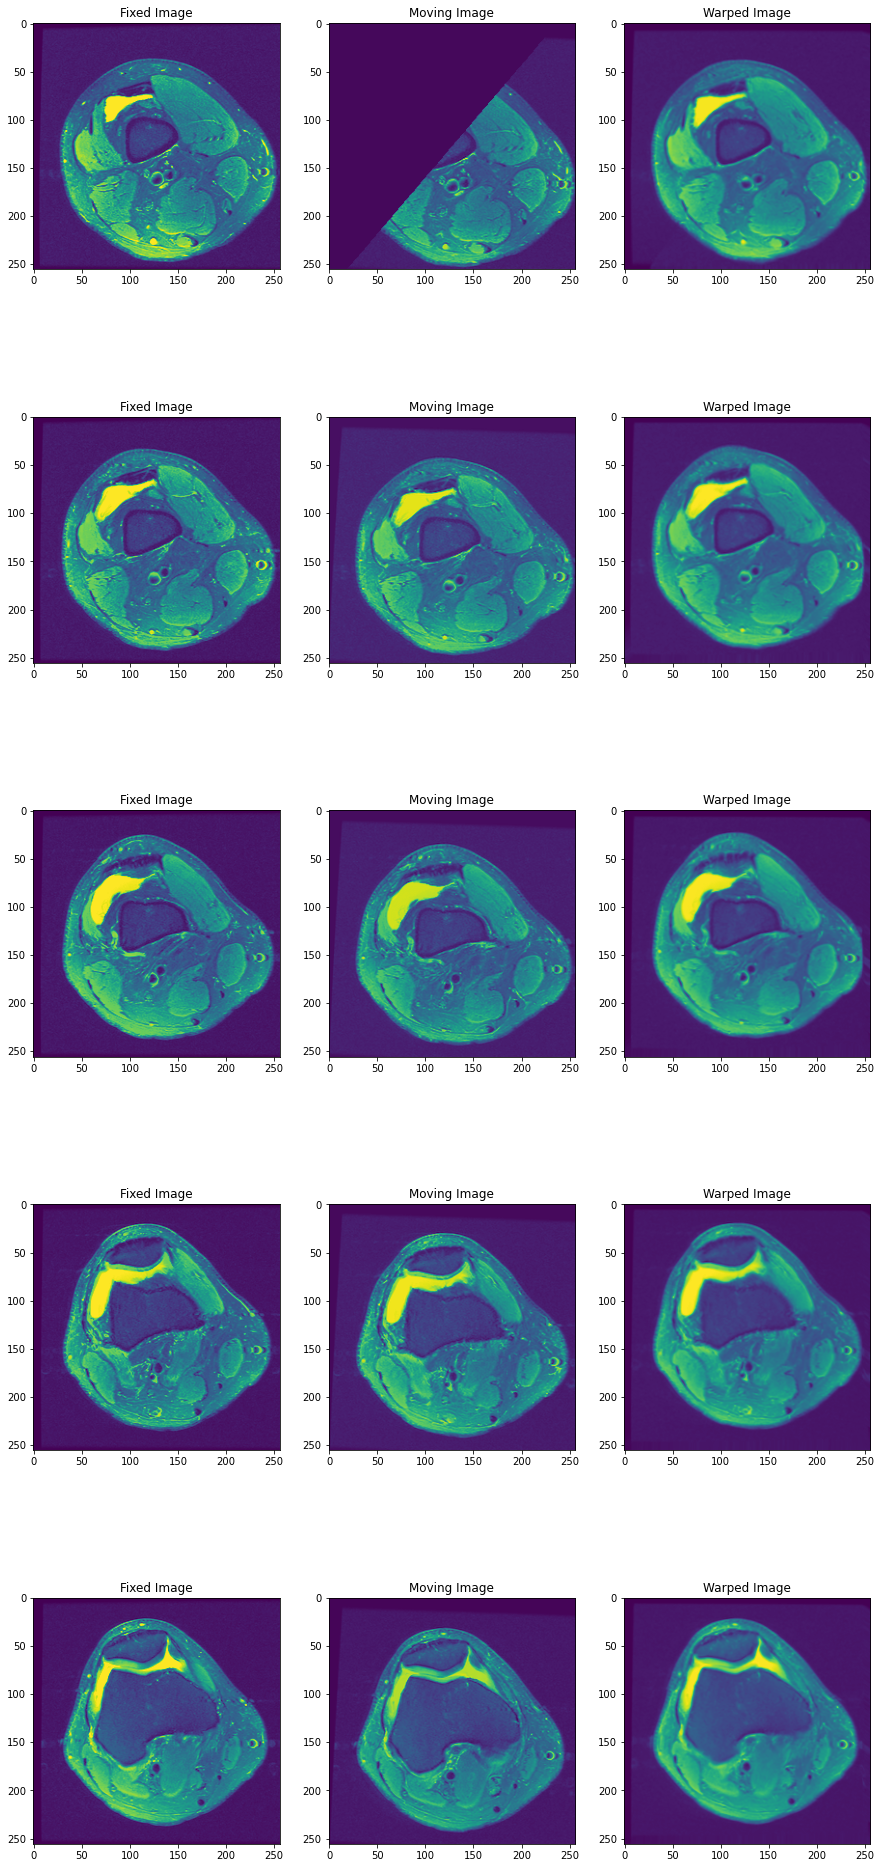

In [25]:
sliceToCheck = 0
fig, axs = plt.subplots(5, 3, figsize=(15, 35))
for i in range(5):
    axs[i, 0].imshow(fixedImg[0,sliceToCheck + i * 5,:,:,0])
    axs[i, 0].set_title("Fixed Image")
    axs[i, 1].imshow(moving_test[0,sliceToCheck + i * 5,:,:,0])
    axs[i, 1].set_title("Moving Image")
    axs[i, 2].imshow(warped_test[0,sliceToCheck + i * 5,:,:,0])
    axs[i, 2].set_title("Warped Image")
plt.show()